<a href="https://colab.research.google.com/github/jdasam/mas1004-2022/blob/main/notebooks/Data_AI_9th_week_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# !pip install -q jmd_imagescraper
# from jmd_imagescraper.core import duckduckgo_search

from pathlib import Path
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from tqdm.auto import tqdm

In [7]:
!wget https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar
!tar -xf artbench-10-imagefolder-split.tar # unzip the downloaded dataset

--2022-11-01 06:06:57--  https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar
Resolving artbench.eecs.berkeley.edu (artbench.eecs.berkeley.edu)... 128.32.37.248
Connecting to artbench.eecs.berkeley.edu (artbench.eecs.berkeley.edu)|128.32.37.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1985385984 (1.8G) [application/x-tar]
Saving to: ‘artbench-10-imagefolder-split.tar’

artbench-10-imagefo 100%[===================>]   1.85G  10.0MB/s    in 2m 28s  

2022-11-01 06:09:27 (12.8 MB/s) - ‘artbench-10-imagefolder-split.tar’ saved [1985385984/1985385984]



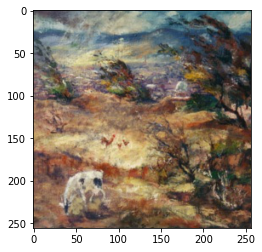

In [10]:
# How to load image
import matplotlib.pyplot as plt

img_path = Path('artbench-10-imagefolder-split/test/expressionism/rudolf-lang_hillside-1953.jpg')
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

In [19]:
# load all the image filename in the dataset directory
from pathlib import Path

dataset_dir = Path('artbench-10-imagefolder-split/')
# dataset_dir.exists(), dataset_dir.is_dir()

train_dir = dataset_dir / 'train'
print(train_dir)

# How can we find all jpg file in the train directory?
jpg_list = list(train_dir.rglob('*.jpg')) # rglob will return iterator, so i will convert it into a list
len(jpg_list), jpg_list[:10]

artbench-10-imagefolder-split/train


(50000,
 [PosixPath('artbench-10-imagefolder-split/train/renaissance/el-greco_st-idelfonso.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/tintoretto_portrait-of-a-procurator-of-st-mark-s.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/pinturicchio_portrait-of-a-boy-1500.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/paolo-veronese_annunciation-1558.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/michelangelo_david-1504.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/raphael_putti-detail-from-the-sistine-madonna-1513.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/pieter-bruegel-the-elder_running-away-the-mother-of-god-into-egypt.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/hieronymus-bosch_passion-of-the-christ-1515-1.jpg'),
  PosixPath('artbench-10-imagefolder-split/train/renaissance/hieronymus-bosch_christ-carrying-the-cross-1.jpg'),
  Posix

In [27]:
glob_list = dataset_dir.glob('*.jpg') # there is no image file in the directory
list(glob_list)

[]

In [25]:
jpg_fn = jpg_list[0]
jpg_fn, jpg_fn.name, jpg_fn.stem, jpg_fn.with_suffix('.png'), jpg_fn.parent

(PosixPath('artbench-10-imagefolder-split/train/renaissance/el-greco_st-idelfonso.jpg'),
 'el-greco_st-idelfonso.jpg',
 'el-greco_st-idelfonso',
 PosixPath('artbench-10-imagefolder-split/train/renaissance/el-greco_st-idelfonso.png'),
 PosixPath('artbench-10-imagefolder-split/train/renaissance'))

In [26]:
jpg_fn.parent.name

'renaissance'

In [47]:
category_names = []
for child in (dataset_dir / 'train').iterdir():
  print(child, child.is_dir())
  if child.is_dir():
    category_names.append(child.name)
category_names = sorted(category_names)

artbench-10-imagefolder-split/train/renaissance True
artbench-10-imagefolder-split/train/._.DS_Store False
artbench-10-imagefolder-split/train/.DS_Store False
artbench-10-imagefolder-split/train/ukiyo_e True
artbench-10-imagefolder-split/train/impressionism True
artbench-10-imagefolder-split/train/art_nouveau True
artbench-10-imagefolder-split/train/baroque True
artbench-10-imagefolder-split/train/expressionism True
artbench-10-imagefolder-split/train/realism True
artbench-10-imagefolder-split/train/post_impressionism True
artbench-10-imagefolder-split/train/romanticism True
artbench-10-imagefolder-split/train/surrealism True


In [50]:
name2idx = {}
for i, name in enumerate(category_names):
  print(i, name)
  name2idx[name] = i 
name2idx

0 art_nouveau
1 baroque
2 expressionism
3 impressionism
4 post_impressionism
5 realism
6 renaissance
7 romanticism
8 surrealism
9 ukiyo_e


{'art_nouveau': 0,
 'baroque': 1,
 'expressionism': 2,
 'impressionism': 3,
 'post_impressionism': 4,
 'realism': 5,
 'renaissance': 6,
 'romanticism': 7,
 'surrealism': 8,
 'ukiyo_e': 9}

In [51]:
name2idx['romanticism']

7

In [63]:


class ImageDataset:
  def __init__(self, dataset_dir):
    self.dir = Path(dataset_dir)
    self.img_fns = list(self.dir.rglob('*.jpg'))
    self.category_names = sorted([child.name for child in self.dir.iterdir() if child.is_dir()])
    
    #make dictionary that directly converts the string name to the correponding idx
    self.name2idx = {name: i for i, name in enumerate(self.category_names)}
    self.transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  def __len__(self):
    return len(self.img_fns)
  
  def __getitem__(self, idx):
    selected_img_fn = self.img_fns[idx] 
    img = Image.open(selected_img_fn).convert('RGB')

    label = selected_img_fn.parent.name
    # Instead of using the category's name in string,
    # we want to convert it to category's index number in integer
    # label_index = self.category_names.index(label)
    label_index = self.name2idx[label]
    img = self.transform(img)

    return img, label_index


  
dataset = ImageDataset('artbench-10-imagefolder-split/train')

len(dataset), dataset[0], dataset.category_names, dataset.name2idx

(50000, (tensor([[[-1.9980, -1.9809, -1.9467,  ...,  0.2453,  0.6221,  0.2624],
           [-2.0152, -1.9809, -1.9638,  ...,  0.3823,  0.1768,  0.6734],
           [-1.9980, -1.9980, -1.9809,  ...,  0.1597,  0.0741,  0.8618],
           ...,
           [-0.8849, -0.4739, -0.0801,  ..., -1.3473, -0.7308,  0.1768],
           [-0.4568,  0.1597,  0.0056,  ..., -1.2959, -0.1828,  0.6906],
           [-0.4739, -0.1828,  0.0569,  ..., -1.1418,  0.5878,  1.3413]],
  
          [[-1.8957, -1.8782, -1.8431,  ..., -0.0924,  0.1877, -0.2150],
           [-1.9132, -1.8782, -1.8606,  ...,  0.0651, -0.2150,  0.2227],
           [-1.8957, -1.8957, -1.8782,  ..., -0.1625, -0.3025,  0.4853],
           ...,
           [-1.5980, -1.1779, -0.7227,  ..., -1.5280, -1.3529, -0.8803],
           [-1.1429, -0.5126, -0.6176,  ..., -1.4755, -0.9328, -0.6001],
           [-1.1954, -0.8803, -0.6001,  ..., -1.3354, -0.2500, -0.0749]],
  
          [[-1.5779, -1.5604, -1.5256,  ..., -0.3404, -0.1661, -0.6890],
    

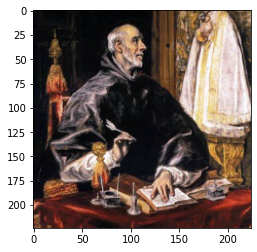

In [66]:

tensor2pil = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    transforms.ToPILImage()
])

img, label = dataset[0]
# plt.imshow(img.permute(1,2,0))
plt.imshow(tensor2pil(img))

In [72]:
def custom_collate(raw_batch):
  # raw_batch is a list of collected items
  # [dataset[0], dataset[1], dataset[2], dataset[3]]
  # print(raw_batch)
  # print('Length of raw batch', len(raw_batch))
  # print(raw_batch[0])

  # each item in the raw_batch is a tuple of (img, label)
  # we want to group them as an [img, img, img, img], [label, label, label, label]
  # instead of [(img, label), (img, label) ~~ ]
  imgs = []
  labels = []
  # for img, label in raw_batch:
  for datasample in raw_batch:
    img, label = datasample
    imgs.append(img)
    labels.append(label)

  return torch.stack(imgs), torch.tensor(labels)

data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=4, 
                                          shuffle=False, 
                                          # collate_fn=custom_collate)
                                          ) #default collate_fn will make the same result

# batch = next(iter(data_loader))
for batch in data_loader:
  batch
  break
imgs, labels = batch
print(imgs.shape, labels.shape)

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [60]:
raw_batch =  [dataset[0], dataset[1], dataset[2], dataset[3]]
print(raw_batch)

[(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FB31F814C50>, 6), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FB31F814090>, 6), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FB31F8141D0>, 6), (<PIL.Image.Image image mode=RGB size=256x256 at 0x7FB31F3E2710>, 6)]


In [75]:
model = torchvision.models.resnet18(pretrained=True)
pred = model(imgs) # imgs is a batch of 4 img of 224x224 RGB pixels  


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
pred.shape

torch.Size([4, 1000])

In [79]:
import torch.nn as nn
# we want to change the last projection layer 
# the last FC layer (nn.Linear) has to have num_out_features of num_classes

print(model.fc)
model.fc = nn.Linear(512, 10)

Linear(in_features=512, out_features=1000, bias=True)


In [80]:
pred = model(imgs)
pred.shape

torch.Size([4, 10])

In [82]:
DEV = 'cuda'

def get_nll_loss(pred, target):
  return -pred[torch.arange(len(target)), target].log().mean()

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

model.to(DEV)
num_epochs = 3
loss_record = []
for i in tqdm(range(num_epochs)):
  num_update_in_epoch = 0
  for batch in tqdm(train_loader, leave=False):
    img, label = batch
    pred = model(img.to(DEV))
    prob = pred.softmax(dim=-1)
    loss = get_nll_loss(prob, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

    num_update_in_epoch += 1
    if num_update_in_epoch > 100:
      break


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

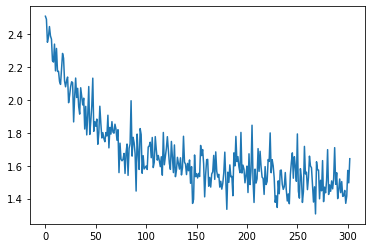

In [83]:
plt.plot(loss_record)

In [85]:
testset = ImageDataset('artbench-10-imagefolder-split/test')
len(testset)

10000

In [90]:
(torch.argmax(pred, dim=-1) == label.to(DEV)).sum()/ len(label)

tensor(0.4375, device='cuda:0')

In [91]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

model.eval()
with torch.inference_mode():
  for batch in test_loader:
    img, label = batch
    pred = model(img.to(DEV))
    accuracy = (torch.argmax(pred, dim=-1) == label.to(DEV)).sum()/ len(label)
    print(accuracy)

tensor(0.6406, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.5781, device='cuda:0')
tensor(0.6406, device='cuda:0')
tensor(0.6406, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.6719, device='cuda:0')
tensor(0.6719, device='cuda:0')
tensor(0.5781, device='cuda:0')
tensor(0.6406, device='cuda:0')
tensor(0.6094, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.5156, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.8281, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.9531, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.8594, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0.9219, device='cuda:0')
tensor(0

In [ ]:
# for i, name in enumerate(category_names):
#   if name == given_name:
#     return i 

In [ ]:
pil2tensor = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

tensor2pil = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
    transforms.ToPILImage()
])


In [4]:
model = torchvision.models.resnet18(pretrained=True)
model.fc

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=1000, bias=True)